In [116]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from torchdiffeq import odeint_adjoint as odeint
import torch.optim as optim
import torch.nn.functional as F

In [226]:
g = 9.81
L = 1.
k = 40.
m = 1.

In [227]:
def dynamics_theta_1(A, B, t):
    w_1 = np.sqrt(g / L)
    w_2 = np.sqrt(g / L + 2. * k / m)
    theta_1 = 0.5 * (A * np.cos(w_1 * t) + B * np.cos(w_2 * t))
    derivative_theta_1 = - 0.5 * (A * w_1 * np.sin(w_1 * t) + B * w_2 * np.sin(w_2 * t))
    return theta_1, derivative_theta_1

def dynamics_theta_2(A, B, t):
    w_1 = np.sqrt(g / L)
    w_2 = np.sqrt(g / L + 2. * k / m)
    theta_2 = 0.5 * (A * np.cos(w_1 * t) - B * np.cos(w_2 * t))
    derivative_theta_2 = - 0.5 * (A * w_1 * np.sin(w_1 * t) - B * w_2 * np.sin(w_2 * t))
    return theta_2, derivative_theta_2

In [239]:
data_size = 10000
t = torch.linspace(0., 2., data_size)
test_t = torch.linspace(0., 4., data_size)
theta_01 = 0.1
theta_02 = 0.05
A = theta_01 + theta_02
B = theta_01 - theta_02

In [229]:
theta_1, derivative_theta_1 = dynamics_theta_1(A, B, t)
theta_2, derivative_theta_2 = dynamics_theta_2(A, B, t)

In [265]:
def graph_sum(theta_1, theta_2):

    plt.figure(figsize=(12, 10))

    plt.subplot(2, 2, 1)
    plt.plot(t, theta_1 + theta_2, label=r"$\theta_1 + \theta_2$")
    plt.plot(t, derivative_theta_1 + derivative_theta_2, label=r"$\frac{d}{dt} (\theta_1 + \theta_2)$")
    plt.title("Trajectories", fontsize = 14)
    plt.xlabel("t", fontsize = 14)
    plt.ylabel(r"$\theta_1 + \theta_2$, $\frac{d}{dt} (\theta_1 + \theta_2)$", fontsize = 14)
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(theta_1 + theta_2, derivative_theta_1 + derivative_theta_2, label=r"$\theta_1 + \theta_2$")
    plt.title("Phase Portrait", fontsize=14)
    plt.xlabel(r"$\theta_1 + \theta_2$", fontsize = 14)
    plt.ylabel(r"$\frac{d}{dt} (\theta_1 + \theta_2)$", fontsize = 14)
    plt.legend()
    
    plt.show()
    
def graph_difference(theta_1, theta_2):
    
    plt.figure(figsize=(12, 10))

    plt.subplot(2, 2, 1)
    plt.plot(t, theta_1 - theta_2, label=r"$\theta_1 - \theta_2$")
    plt.plot(t, derivative_theta_1 - derivative_theta_2, label=r"$\frac{d}{dt} (\theta_1 - \theta_2)$")
    plt.title("Trajectories", fontsize = 14)
    plt.xlabel("t", fontsize = 14)
    plt.ylabel(r"$\theta_1 - \theta_2$, $\frac{d}{dt} (\theta_1 - \theta_2)$", fontsize = 14)
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(theta_1 - theta_2, derivative_theta_1 - derivative_theta_2, label=r"$\theta_1 - \theta_2$")
    plt.title("Phase Portrait", fontsize=14)
    plt.xlabel(r"$\theta_1 - \theta_2$", fontsize = 14)
    plt.ylabel(r"$\frac{d}{dt} (\theta_1 - \theta_2)$", fontsize = 14)
    plt.legend()
    
    plt.show()

def graph_1(theta_1):
    
    plt.figure(figsize=(12, 10))
    
    plt.subplot(4, 2, 5)
    plt.plot(t, theta_1, label=r"$\theta_1$")
    plt.plot(t, derivative_theta_1, label=r"$\frac{d}{dt} \theta_1$")
    plt.title("Trajectories", fontsize = 14)
    plt.xlabel("t", fontsize = 14)
    plt.ylabel(r"$\theta_1$, $\frac{d}{dt} \theta_1$", fontsize = 14)
    plt.legend()

    plt.subplot(4, 2, 6)
    plt.plot(theta_1, derivative_theta_1, label=r"$\theta_1$")
    plt.title("Phase Portrait", fontsize=14)
    plt.xlabel(r"$\theta_1$", fontsize = 14)
    plt.ylabel(r"$\frac{d}{dt} \theta_1$", fontsize = 14)
    plt.legend()
    
    plt.show()

def graph_2(theta_2):
    
    plt.figure(figsize=(12, 10))
    
    plt.subplot(4, 2, 7)
    plt.plot(t, theta_2, label=r"$\theta_2$")
    plt.plot(t, derivative_theta_2, label=r"$\frac{d}{dt} \theta_2$")
    plt.title("Trajectories", fontsize = 14)
    plt.xlabel("t", fontsize = 14)
    plt.ylabel(r"$\theta_2$, $\frac{d}{dt} \theta_2$", fontsize = 14)
    plt.legend()

    plt.subplot(4, 2, 8)
    plt.plot(theta_2, derivative_theta_2, label=r"$\theta_2$")
    plt.title("Phase Portrait", fontsize=14)
    plt.xlabel(r"$\theta_2$", fontsize = 14)
    plt.ylabel(r"$\frac{d}{dt} \theta_2$", fontsize = 14)
    plt.legend()
    
    plt.show()

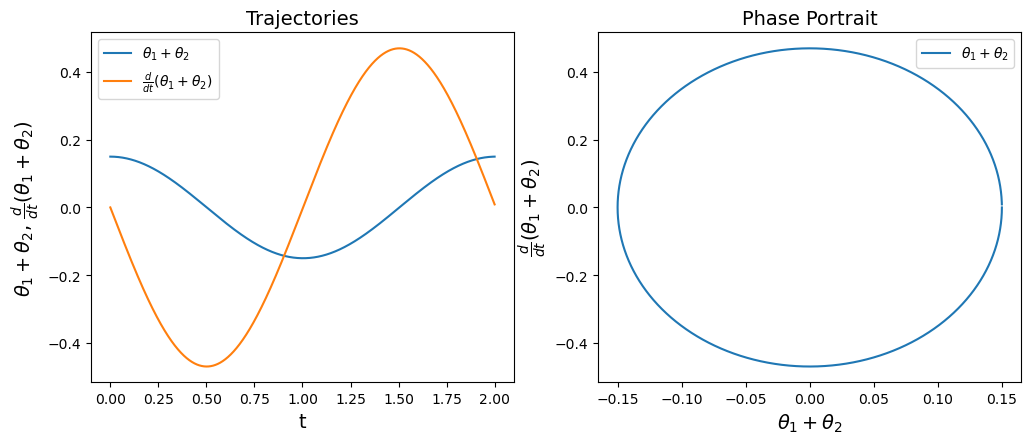

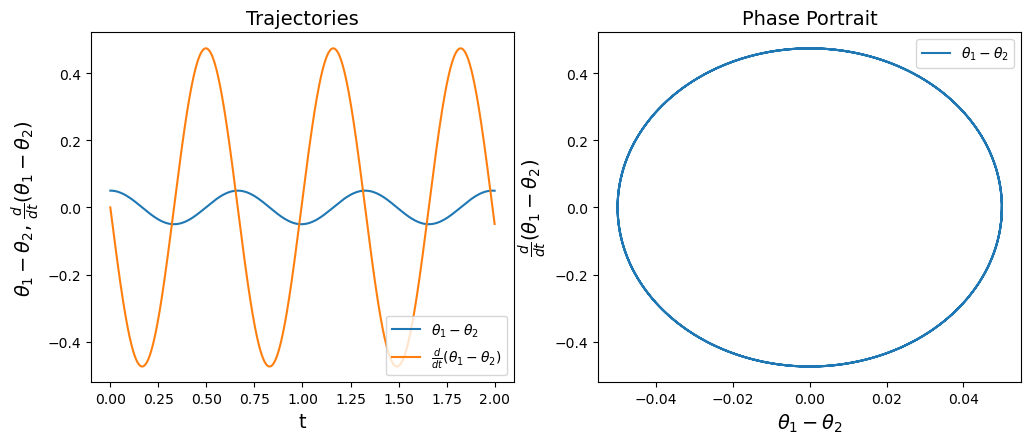

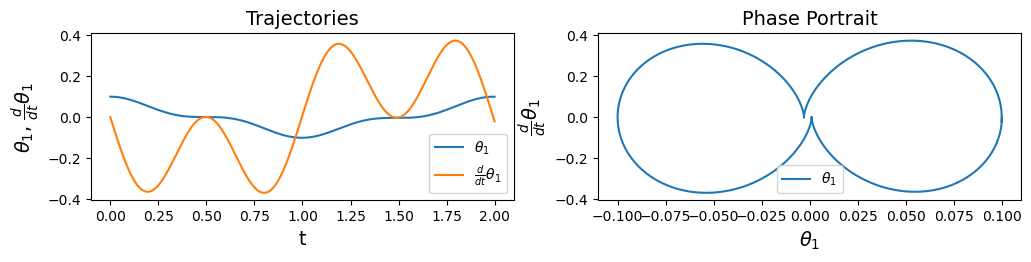

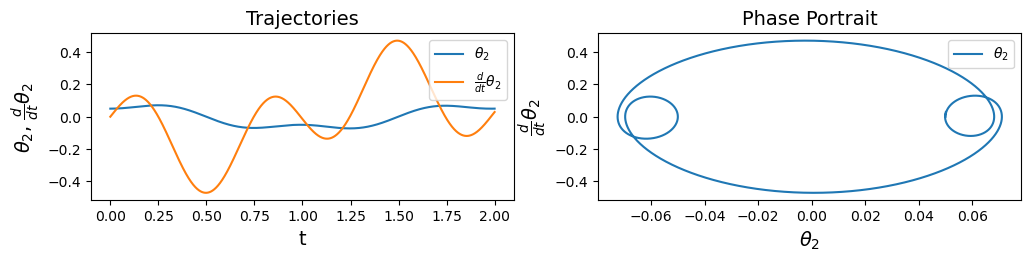

In [266]:
graph_sum(theta_1, theta_2)
graph_difference(theta_1, theta_2)
graph_1(theta_1)
graph_2(theta_2)

In [232]:
true_h0 = torch.tensor([[0., A, 0., B]])
true_A = torch.tensor([[0, 1, 0, 0],
                       [-g / L, 0, 0, 0],
                       [0, 0, 0, 1],
                       [0, 0,  -(g / L + 2 * k / m), 0]])

class Lambda(nn.Module):
    def forward(self, t_torch, h):
        return h @ true_A

with torch.no_grad():
    true_h = odeint(Lambda(), true_h0, t)
    
with torch.no_grad():
    test_h = odeint(Lambda(), true_h0, test_t)

In [274]:
def visualize_sum(true_h, pred_h=None, save=False):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].plot(t.numpy(), true_h.numpy()[:, 0, 1], label=r"$\theta_1 + \theta_2$")
    axs[0].plot(t.numpy(), true_h.numpy()[:, 0, 0], label=r"$\frac{d}{dt} (\theta_1 + \theta_2)$")
    axs[0].set_xlabel("t", fontsize = 14)
    axs[0].set_ylabel(r"$\theta_1 + \theta_2$, $\frac{d}{dt} (\theta_1 + \theta_2)$", fontsize = 14)
    axs[0].set_title('Trajectories', fontsize = 14)
    axs[0].legend()

    axs[1].plot(true_h.numpy()[:, 0, 1], true_h.numpy()[:, 0, 0], label=r"$\theta_1 + \theta_2$")
    axs[1].set_xlabel(r"$\theta_1 + \theta_2$", fontsize = 14)
    axs[1].set_ylabel(r"$\frac{d}{dt} (\theta_1 + \theta_2)$", fontsize = 14)
    axs[1].set_title("Phase Portrait", fontsize=14)
    axs[1].legend()
    
    if pred_h is not None:
        axs[0].plot(t.numpy(), pred_h.numpy()[:, 0, 1], 'g--', label=r"$\theta_1 + \theta_2$ pred")
        axs[0].plot(t.numpy(), pred_h.numpy()[:, 0, 0], 'r--', label=r"$\frac{d}{dt} (\theta_1 + \theta_2)$ pred")
        axs[0].legend()

        axs[1].plot(pred_h.numpy()[:, 0, 1], pred_h.numpy()[:, 0, 0], '--', label=r"$\theta_1 + \theta_2$ pred")
        axs[1].legend()
        
    if save:
        fig.savefig("Graph_sum.png")
        
    plt.show()
    
def visualize_difference(true_h, pred_h=None, save=False):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].plot(t.numpy(), true_h.numpy()[:, 0, 3], label=r"$\theta_1 - \theta_2$")
    axs[0].plot(t.numpy(), true_h.numpy()[:, 0, 2], label=r"$\frac{d}{dt} (\theta_1 - \theta_2)$")
    axs[0].set_xlabel("t", fontsize = 14)
    axs[0].set_ylabel(r"$\theta_1 - \theta_2$, $\frac{d}{dt} (\theta_1 - \theta_2)$", fontsize = 14)
    axs[0].set_title('Trajectories', fontsize = 14)
    axs[0].legend()

    axs[1].plot(true_h.numpy()[:, 0, 3], true_h.numpy()[:, 0, 2], label=r"$\theta_1 - \theta_2$")
    axs[1].set_xlabel(r"$\theta_1 - \theta_2$", fontsize = 14)
    axs[1].set_ylabel(r"$\frac{d}{dt} (\theta_1 - \theta_2)$", fontsize = 14)
    axs[1].set_title("Phase Portrait", fontsize=14)
    axs[1].legend()
    
    if pred_h is not None:
        axs[0].plot(t.numpy(), pred_h.numpy()[:, 0, 3], 'g--', label=r"$\theta_1 - \theta_2$ pred")
        axs[0].plot(t.numpy(), pred_h.numpy()[:, 0, 2], 'r--', label=r"$\frac{d}{dt} (\theta_1 - \theta_2)$ pred")
        axs[0].legend()

        axs[1].plot(pred_h.numpy()[:, 0, 3], pred_h.numpy()[:, 0, 2], '--', label=r"$\theta_1 - \theta_2$ pred")
        axs[1].legend()
        
    if save:
        fig.savefig("Graph_difference.png")
        
    plt.show()
    
def visualize_1(true_h, pred_h=None, save=False):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].plot(t.numpy(), 0.5 * (true_h.numpy()[:, 0, 1] + true_h.numpy()[:, 0, 3]), label=r"$\theta_1$")
    axs[0].plot(t.numpy(), 0.5 * (true_h.numpy()[:, 0, 0] + true_h.numpy()[:, 0, 2]), label=r"$\frac{d}{dt} \theta_1$")
    axs[0].set_xlabel("t", fontsize = 14)
    axs[0].set_ylabel(r"$\theta_1$, $\frac{d}{dt} \theta_1$", fontsize = 14)
    axs[0].set_title('Trajectories', fontsize = 14)
    axs[0].legend()

    axs[1].plot(0.5 * (true_h.numpy()[:, 0, 1] + true_h.numpy()[:, 0, 3]), 0.5 * (true_h.numpy()[:, 0, 0] + true_h.numpy()[:, 0, 2]), label=r"$\theta_1$")
    axs[1].set_xlabel(r"$\theta_1$", fontsize = 14)
    axs[1].set_ylabel(r"$\frac{d}{dt} \theta_1$", fontsize = 14)
    axs[1].set_title("Phase Portrait", fontsize=14)
    axs[1].legend()
    
    if pred_h is not None:
        axs[0].plot(t.numpy(), 0.5 * (pred_h.numpy()[:, 0, 1] + pred_h.numpy()[:, 0, 3]), 'g--', label=r"$\theta_1$ pred")
        axs[0].plot(t.numpy(), 0.5 * (pred_h.numpy()[:, 0, 0] + pred_h.numpy()[:, 0, 2]), 'r--', label=r"$\frac{d}{dt} \theta_1$ pred")
        axs[0].legend()

        axs[1].plot(0.5 * (pred_h.numpy()[:, 0, 1] + pred_h.numpy()[:, 0, 3]), 0.5 * (pred_h.numpy()[:, 0, 0] + pred_h.numpy()[:, 0, 2]), '--', label=r"$\theta_1$ pred")
        axs[1].legend()
        
    if save:
        fig.savefig("Graph_1.png")
        
    plt.show()
    
def visualize_2(true_h, pred_h=None, save=False):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].plot(t.numpy(), 0.5 * (true_h.numpy()[:, 0, 1] - true_h.numpy()[:, 0, 3]), label=r"$\theta_2$")
    axs[0].plot(t.numpy(), 0.5 * (true_h.numpy()[:, 0, 0] - true_h.numpy()[:, 0, 2]), label=r"$\frac{d}{dt} \theta_2$")
    axs[0].set_xlabel("t", fontsize = 14)
    axs[0].set_ylabel(r"$\theta_2$, $\frac{d}{dt} \theta_2$", fontsize = 14)
    axs[0].set_title('Trajectories', fontsize = 14)
    axs[0].legend()

    axs[1].plot(0.5 * (true_h.numpy()[:, 0, 1] - true_h.numpy()[:, 0, 3]), 0.5 * (true_h.numpy()[:, 0, 0] - true_h.numpy()[:, 0, 2]), label=r"$\theta_2$")
    axs[1].set_xlabel(r"$\theta_2$", fontsize = 14)
    axs[1].set_ylabel(r"$\frac{d}{dt} \theta_2$", fontsize = 14)
    axs[1].set_title("Phase Portrait", fontsize=14)
    axs[1].legend()
    
    if pred_h is not None:
        axs[0].plot(t.numpy(), 0.5 * (pred_h.numpy()[:, 0, 1] - pred_h.numpy()[:, 0, 3]), 'g--', label=r"$\theta_2$ pred")
        axs[0].plot(t.numpy(), 0.5 * (pred_h.numpy()[:, 0, 0] - pred_h.numpy()[:, 0, 2]), 'r--', label=r"$\frac{d}{dt} \theta_2$ pred")
        axs[0].legend()

        axs[1].plot(0.5 * (pred_h.numpy()[:, 0, 1] - pred_h.numpy()[:, 0, 3]), 0.5 * (pred_h.numpy()[:, 0, 0] - pred_h.numpy()[:, 0, 2]), '--', label=r"$\theta_2$ pred")
        axs[1].legend()
        
    if save:
        fig.savefig("Graph_2.png")
        
    plt.show()

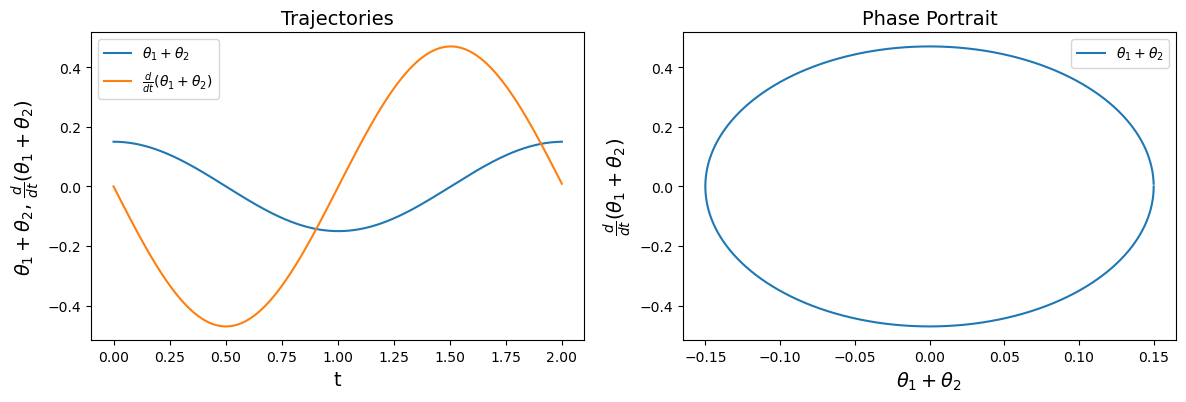

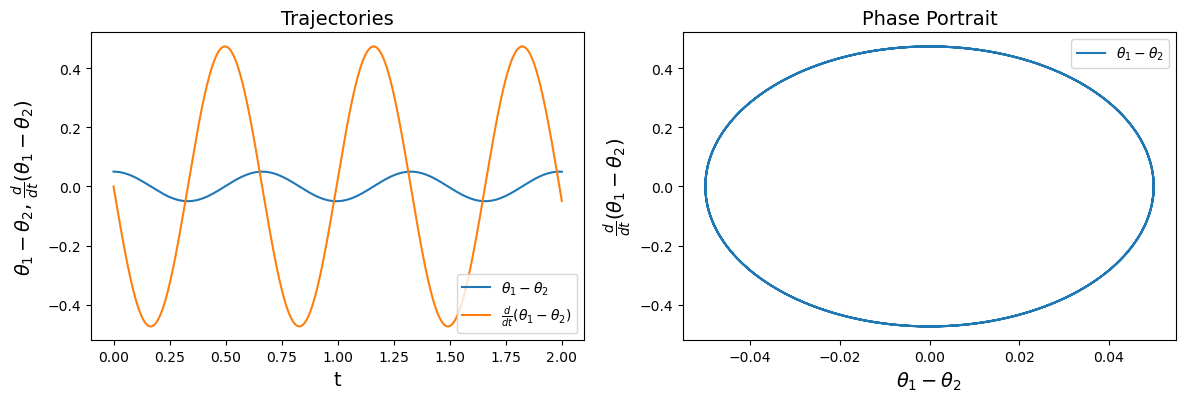

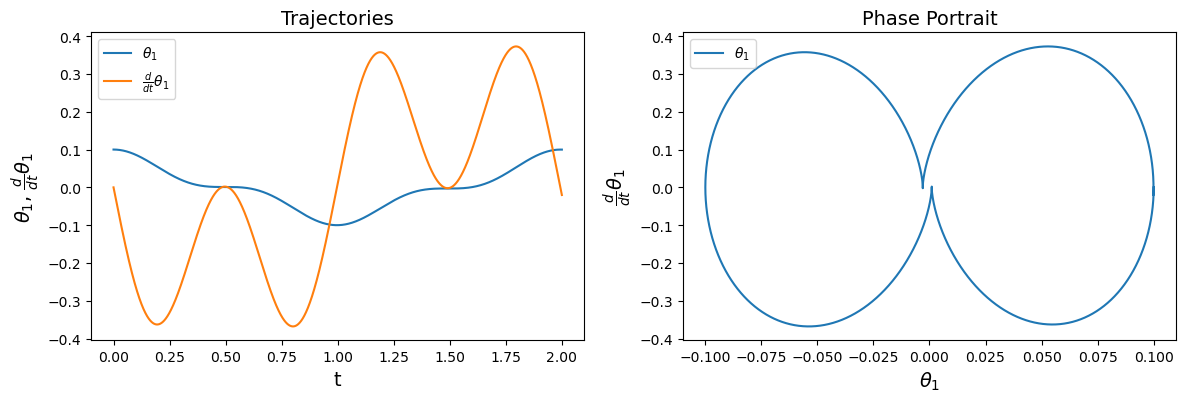

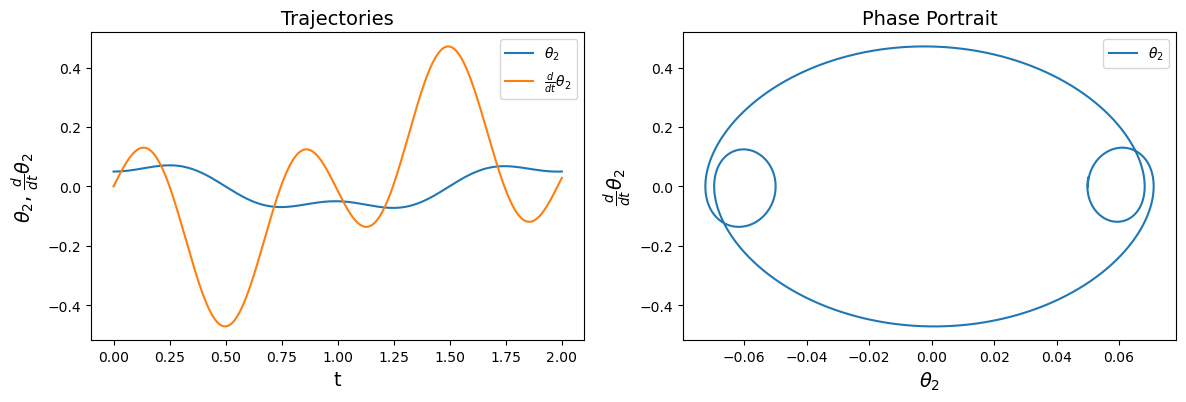

In [271]:
visualize_sum(true_h)
visualize_difference(true_h)
visualize_1(true_h)
visualize_2(true_h)

In [234]:
class ODEFunc(nn.Module):
    def __init__(self):
        super(ODEFunc, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(4, 2048),
            nn.Tanh(),
            nn.Linear(2048, 4)
        )

    def forward(self, t, h):
        return self.net(h)

In [235]:
def get_data(batch_time=32):
    index_range = np.arange(data_size)
    t0 = np.random.choice(index_range[:-batch_time])
    idx = torch.tensor(np.array([t0 + i for i in range(batch_time)]))
    batch_h = true_h[idx]
    return batch_h[0], t[idx], batch_h

test_batch_h0, test_batch_t, test_batch_h = get_data()

Iter 0020 | Total Loss 0.803990


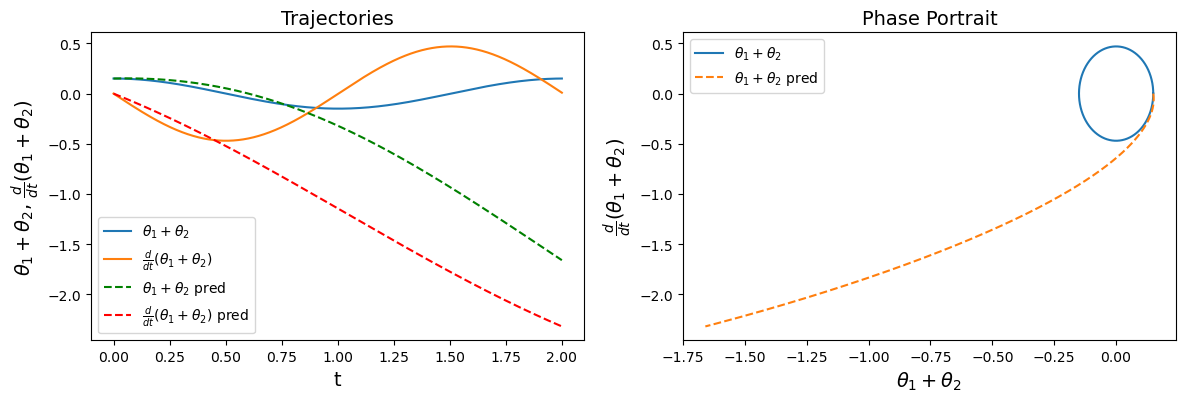

Iter 0040 | Total Loss 0.117616


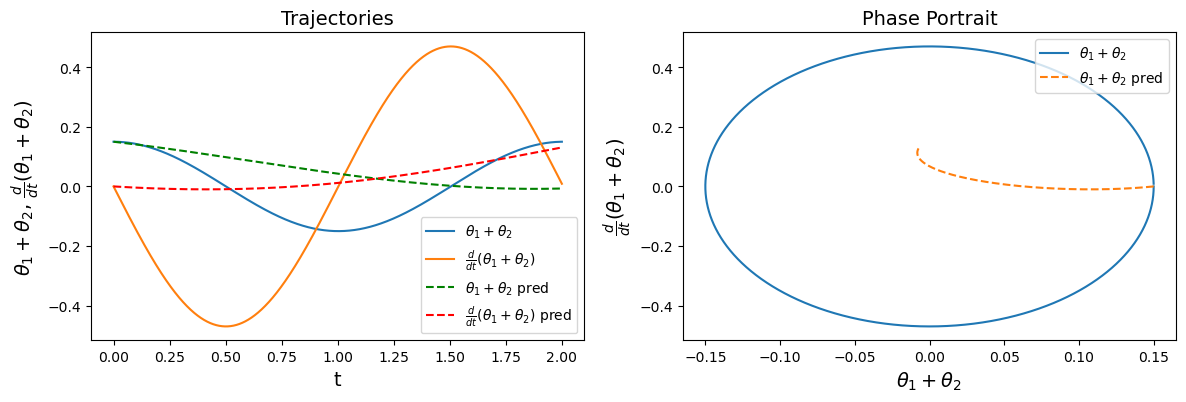

Iter 0060 | Total Loss 0.266296


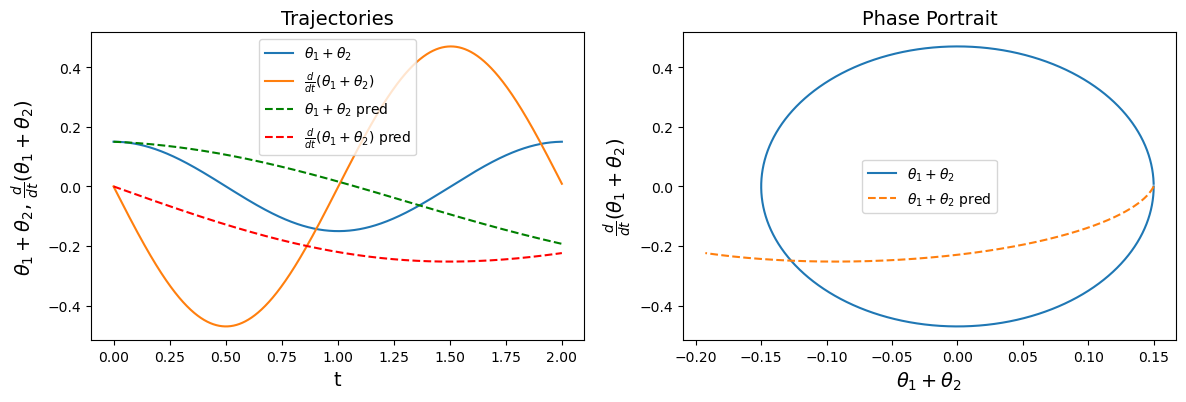

Iter 0080 | Total Loss 0.172272


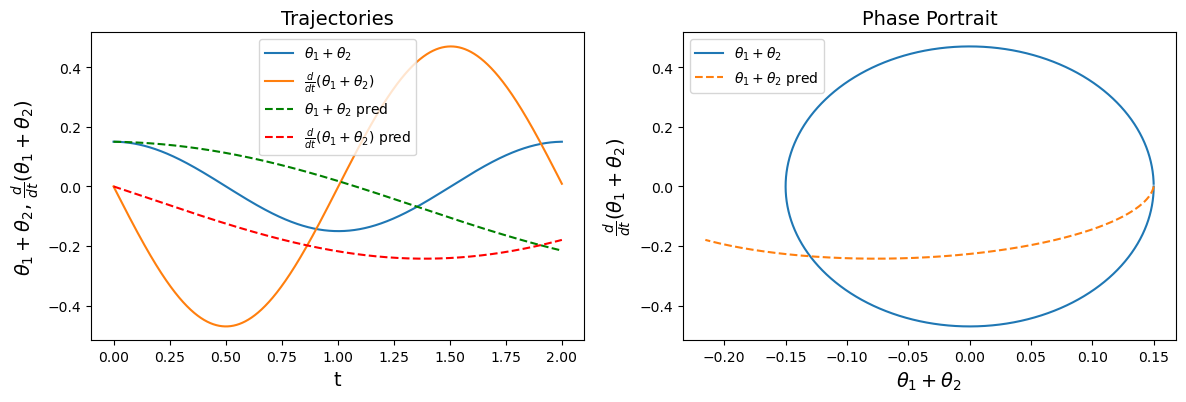

Iter 0100 | Total Loss 0.066965


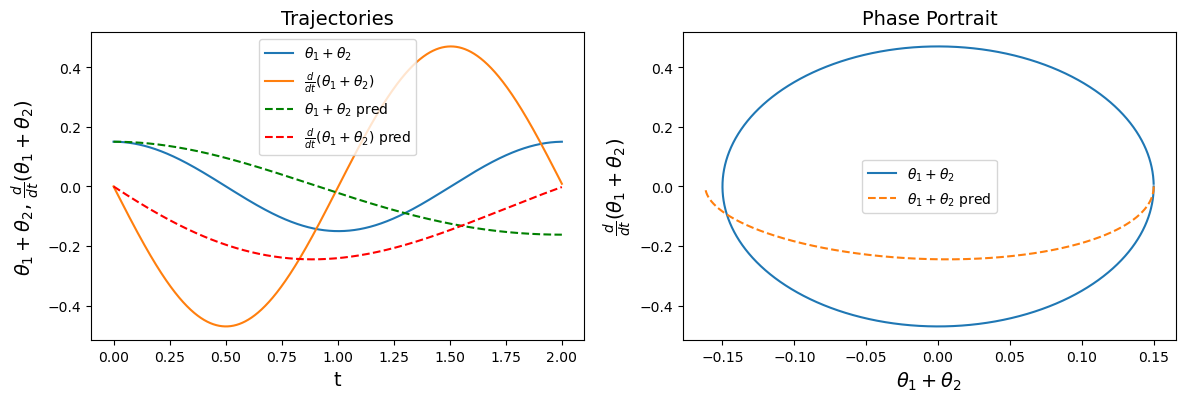

Iter 0120 | Total Loss 0.075035


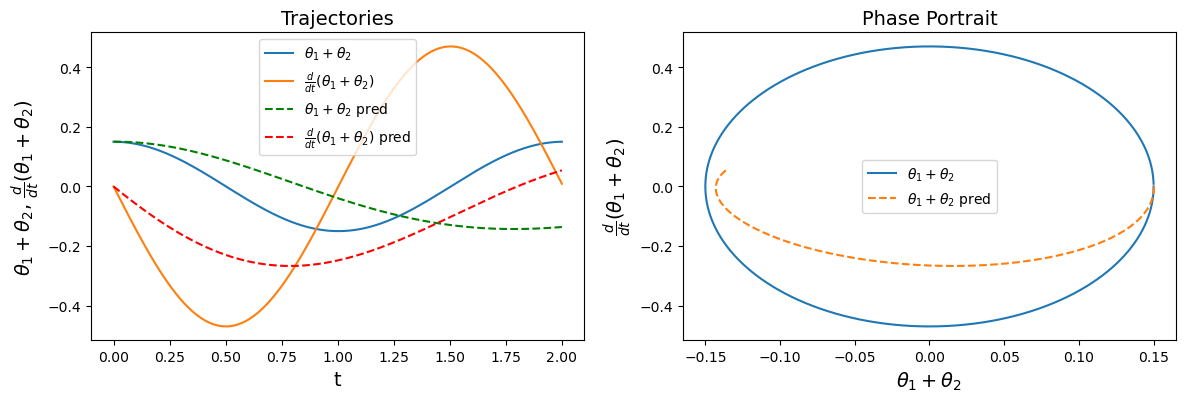

Iter 0140 | Total Loss 0.058923


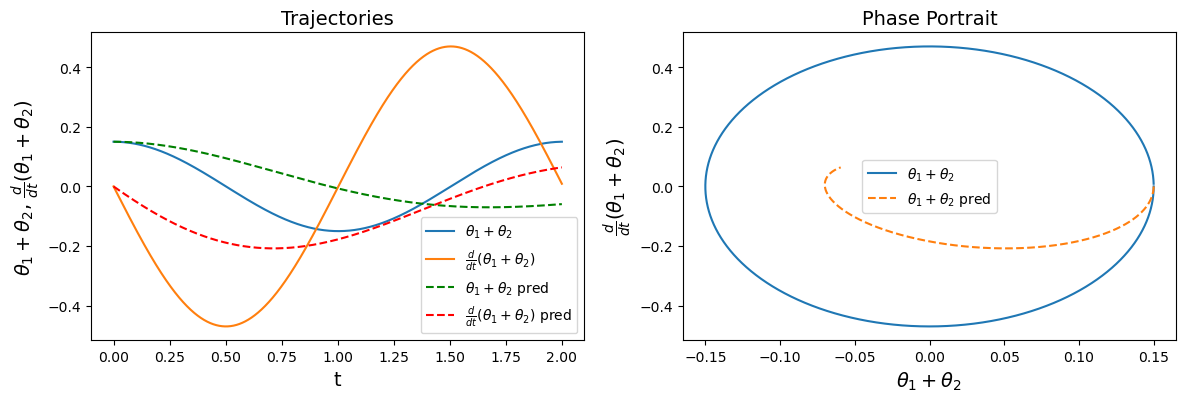

Iter 0160 | Total Loss 0.123196


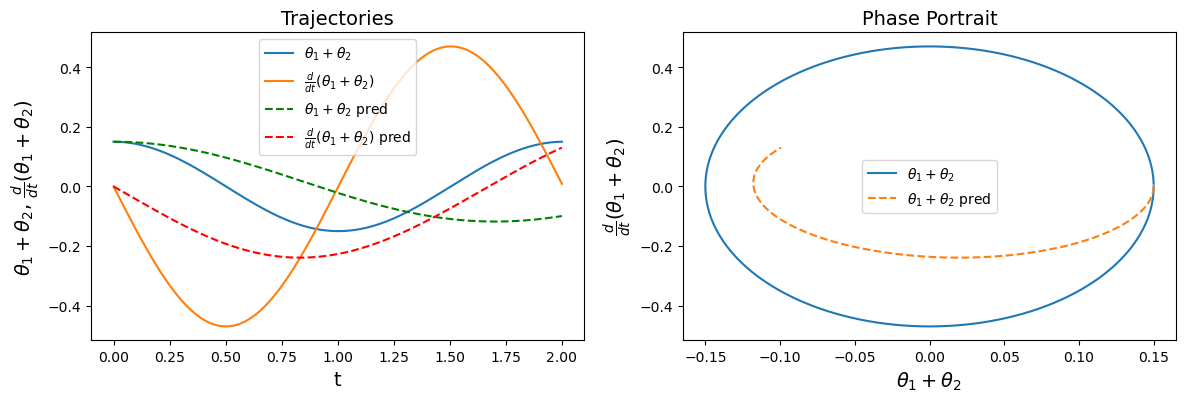

Iter 0180 | Total Loss 0.063310


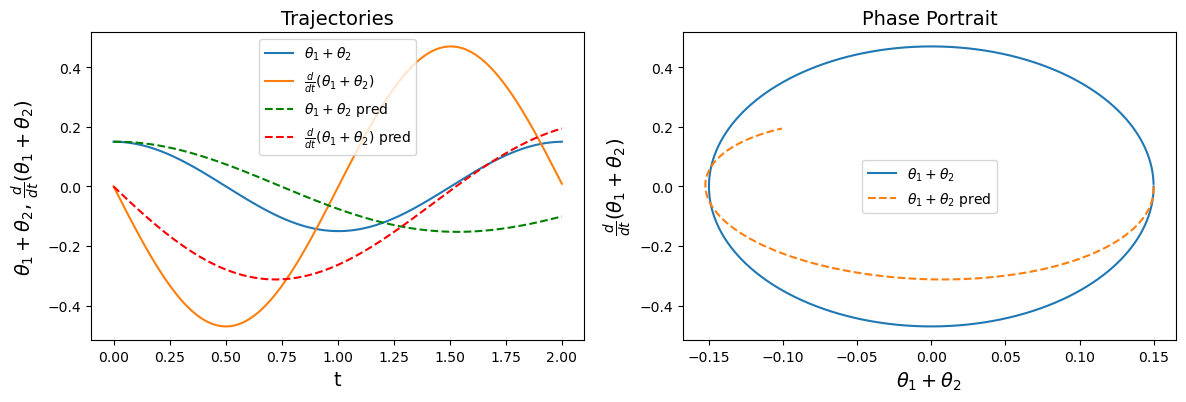

Iter 0200 | Total Loss 0.068784


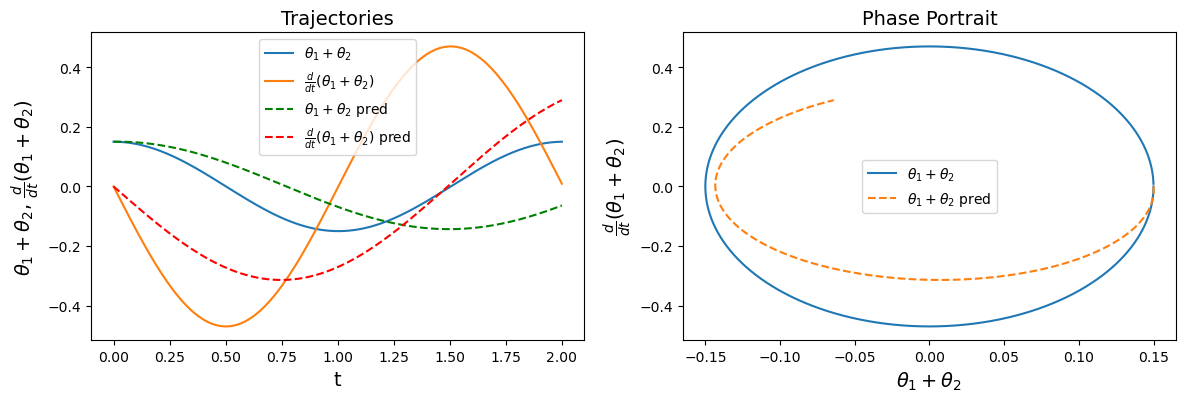

Iter 0220 | Total Loss 0.054673


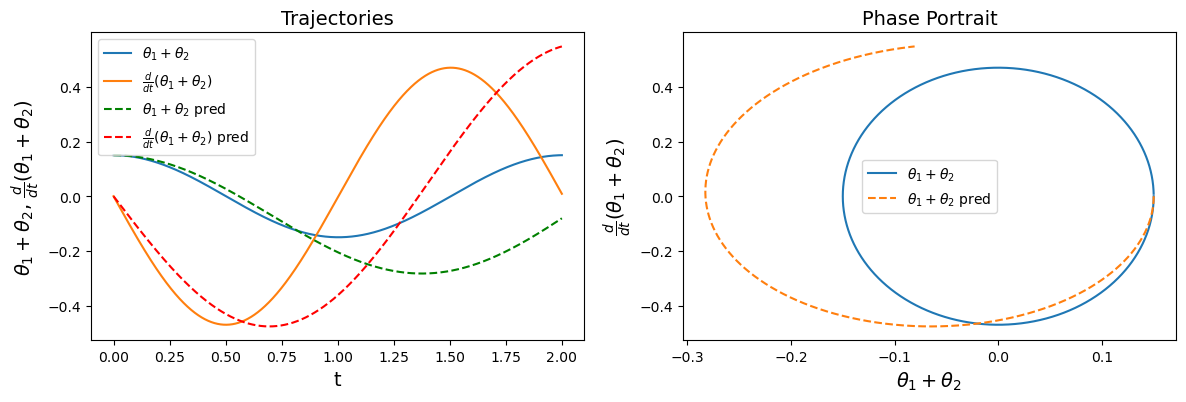

Iter 0240 | Total Loss 0.044746


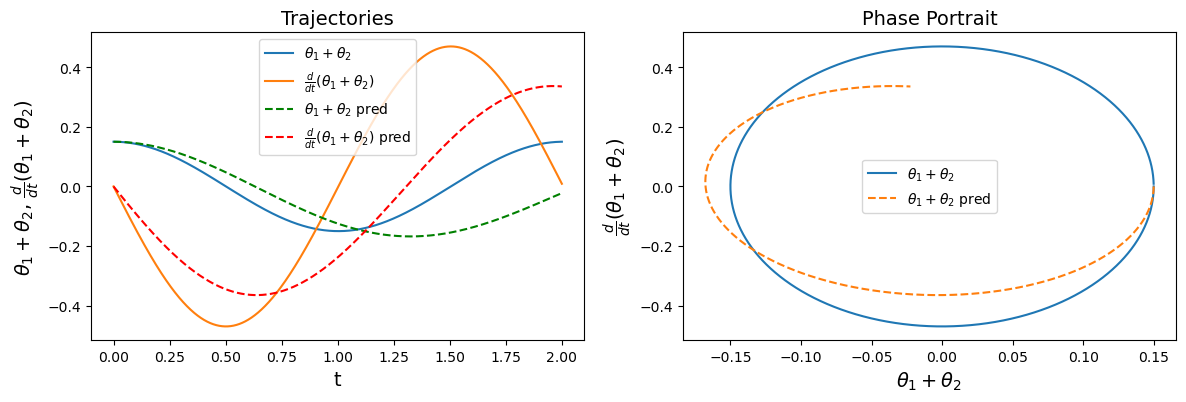

Iter 0260 | Total Loss 0.107483


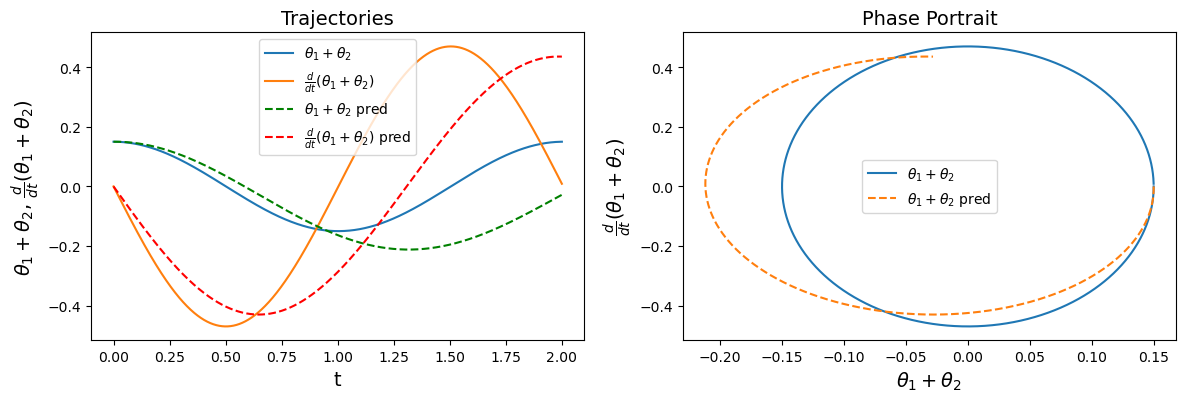

Iter 0280 | Total Loss 0.156331


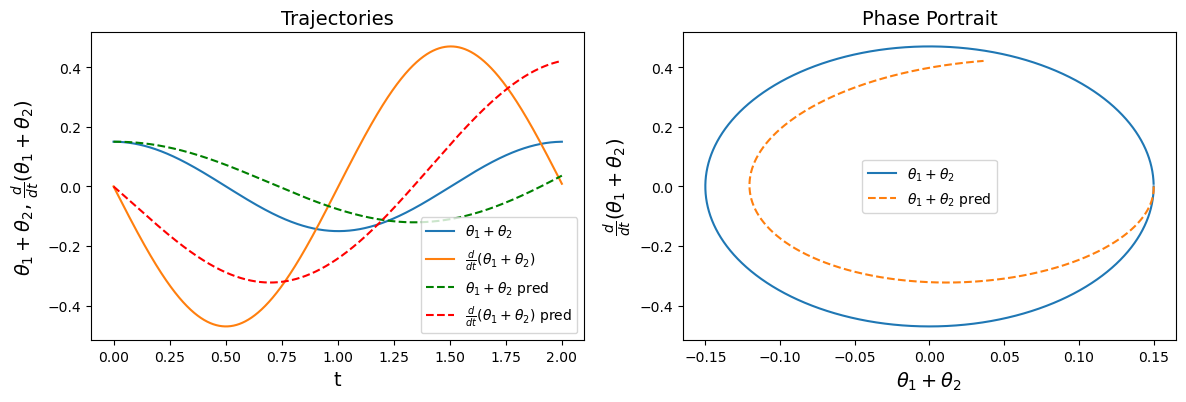

Iter 0300 | Total Loss 0.167072


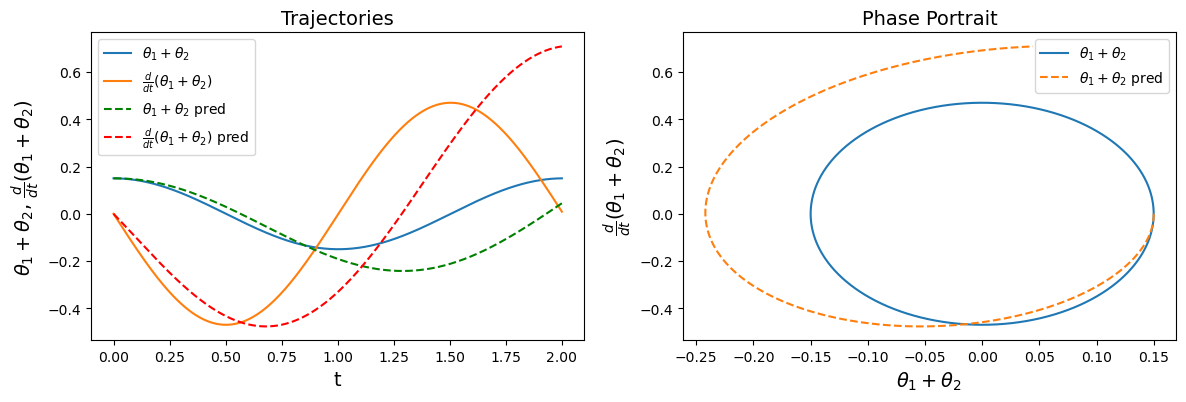

Iter 0320 | Total Loss 0.038186


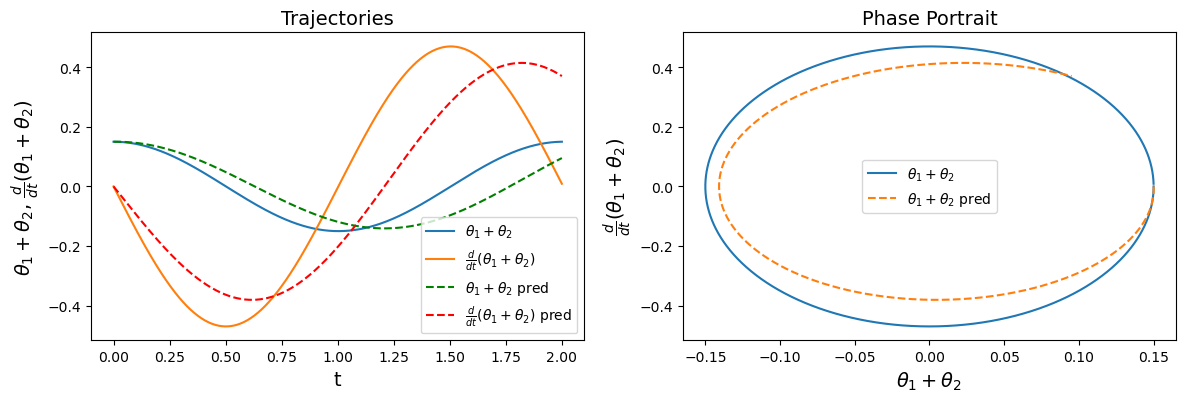

Iter 0340 | Total Loss 0.062675


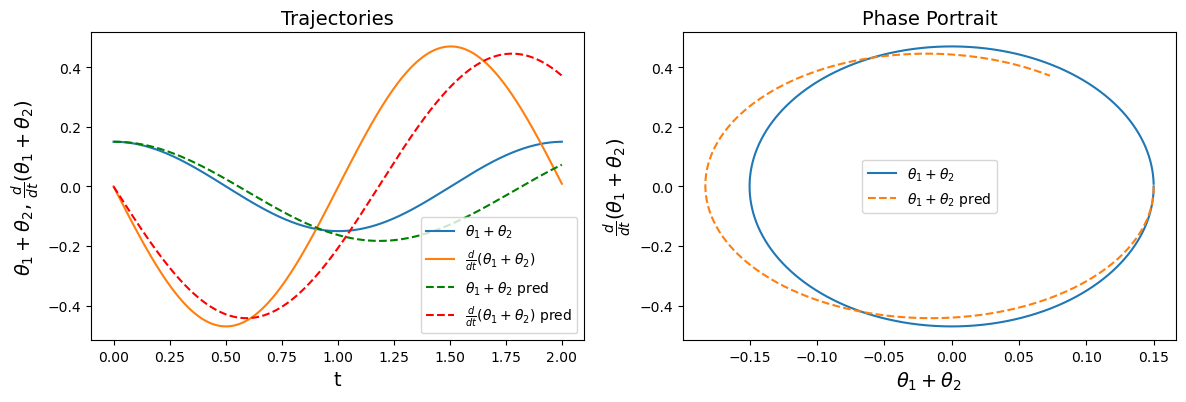

Iter 0360 | Total Loss 0.043834


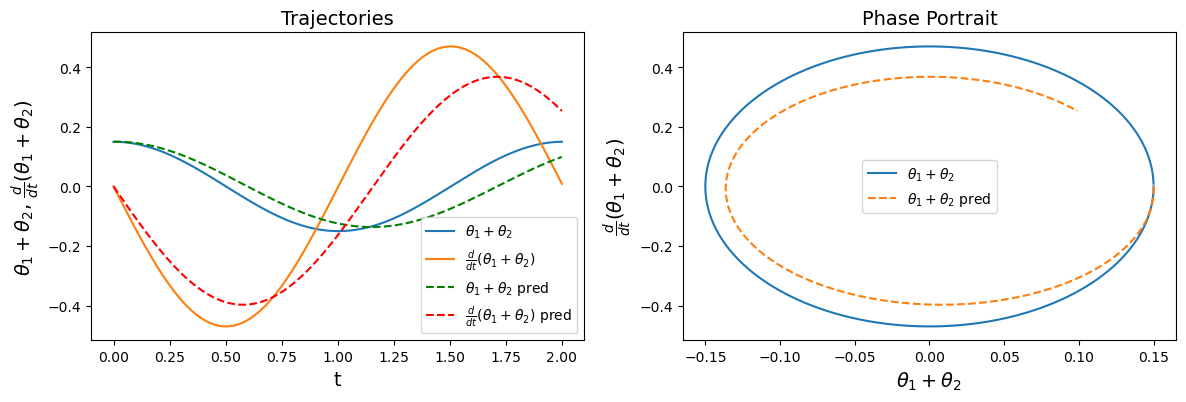

Iter 0380 | Total Loss 0.044460


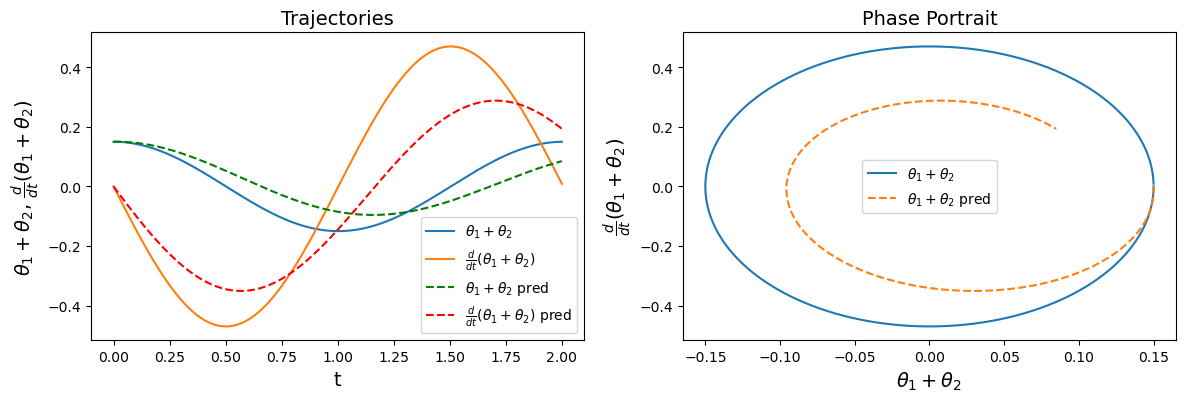

Iter 0400 | Total Loss 0.038028


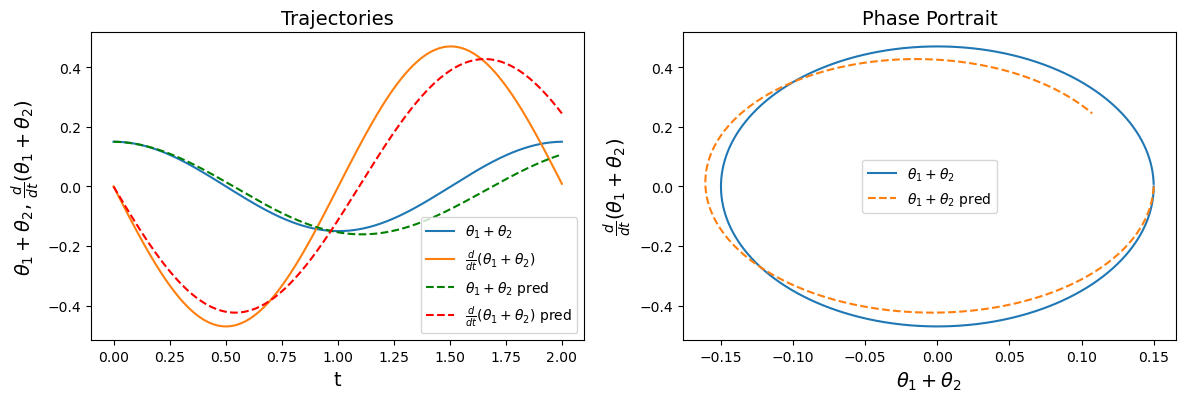

Iter 0420 | Total Loss 0.033770


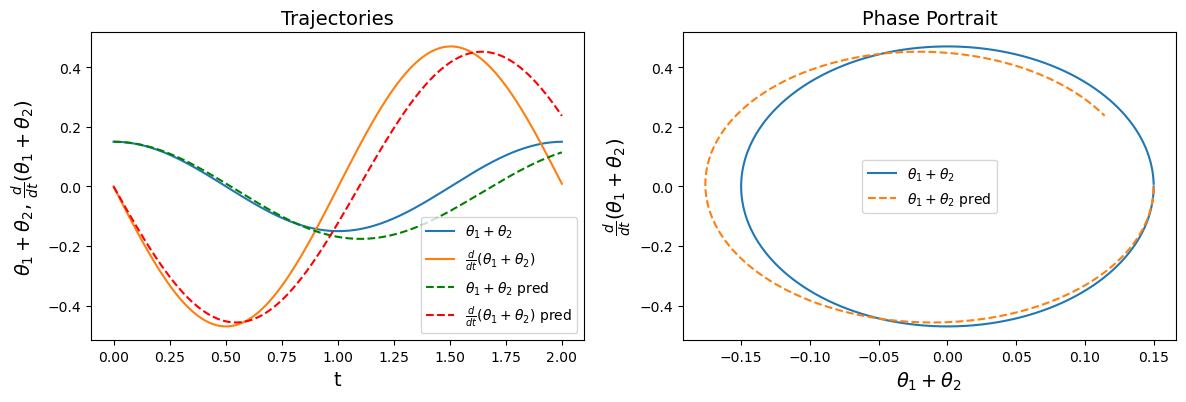

Iter 0440 | Total Loss 0.042004


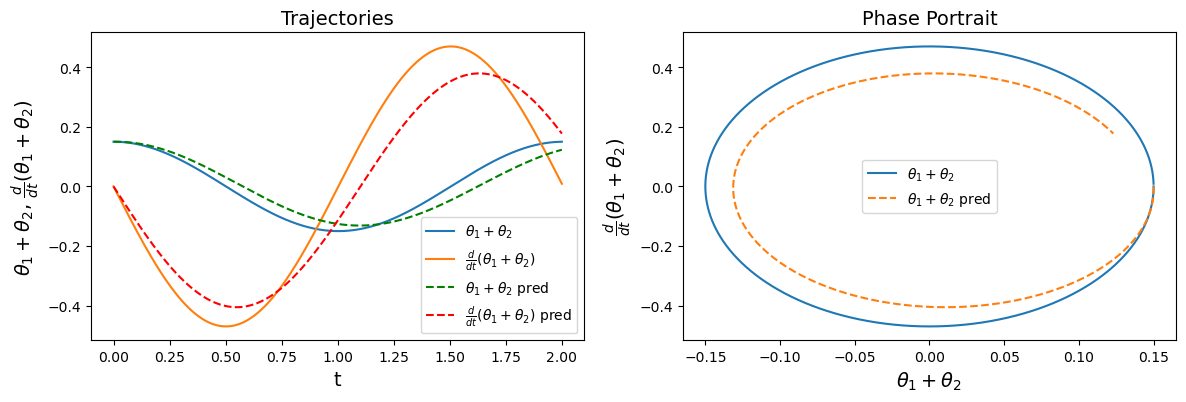

Iter 0460 | Total Loss 0.034013


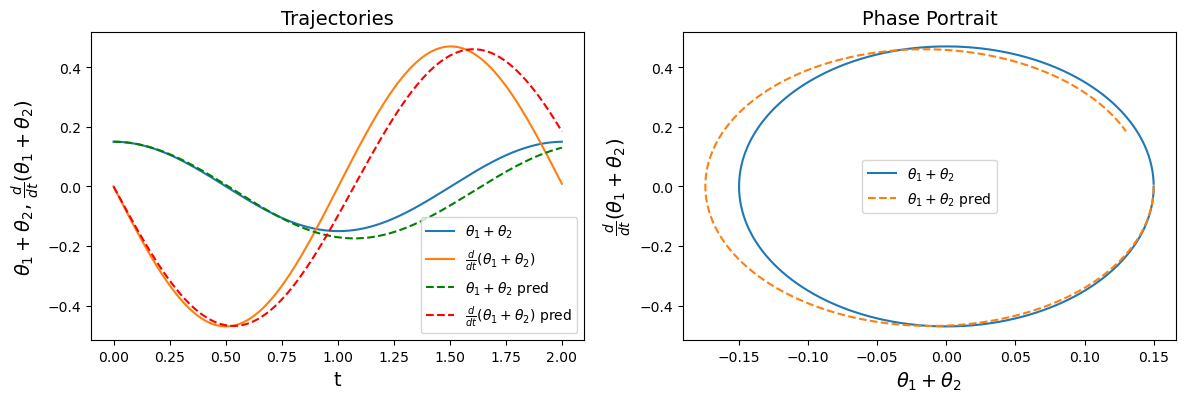

Iter 0480 | Total Loss 0.040853


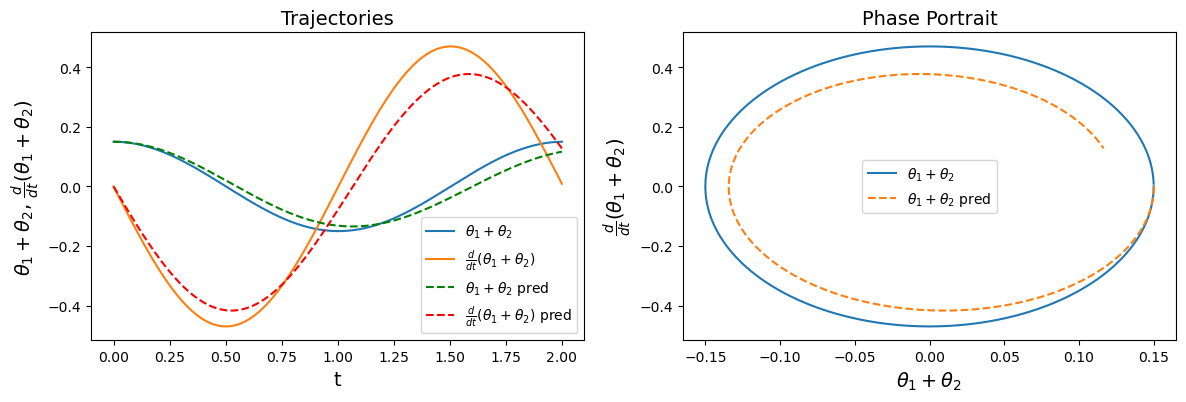

Iter 0500 | Total Loss 0.028159


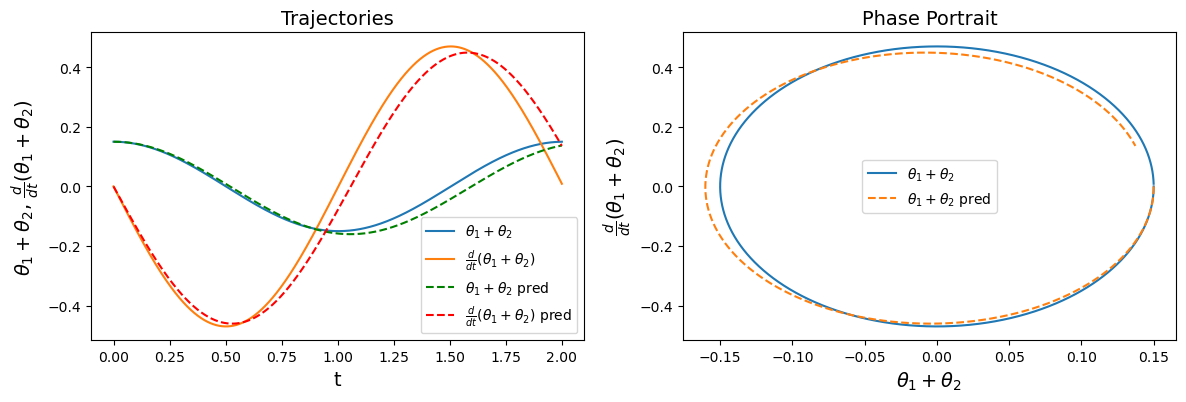

In [237]:
iterations = 500
test_freq = 20

func = ODEFunc()
optimizer = optim.Adam(func.parameters(), lr=0.0004)

for iteration in range(1, iterations + 1):
    optimizer.zero_grad()
    batch_h0, batch_t, batch_h = get_data()
    pred_h = odeint(func, batch_h0, batch_t)
    loss = torch.mean(F.mse_loss(pred_h, batch_h))
    loss.backward()
    optimizer.step()

    if iteration % test_freq == 0:
        with torch.no_grad():
            pred_h = odeint(func, true_h0, t)
            loss = torch.mean(F.mse_loss(pred_h, true_h))
            print('Iter {:04d} | Total Loss {:.6f}'.format(iteration, loss.item()))
            visualize_sum(true_h, pred_h)

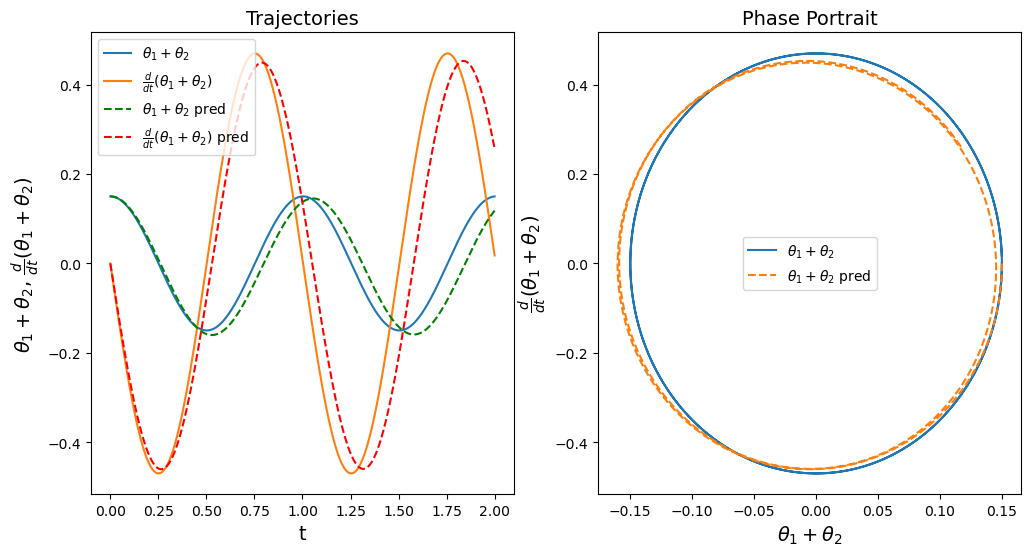

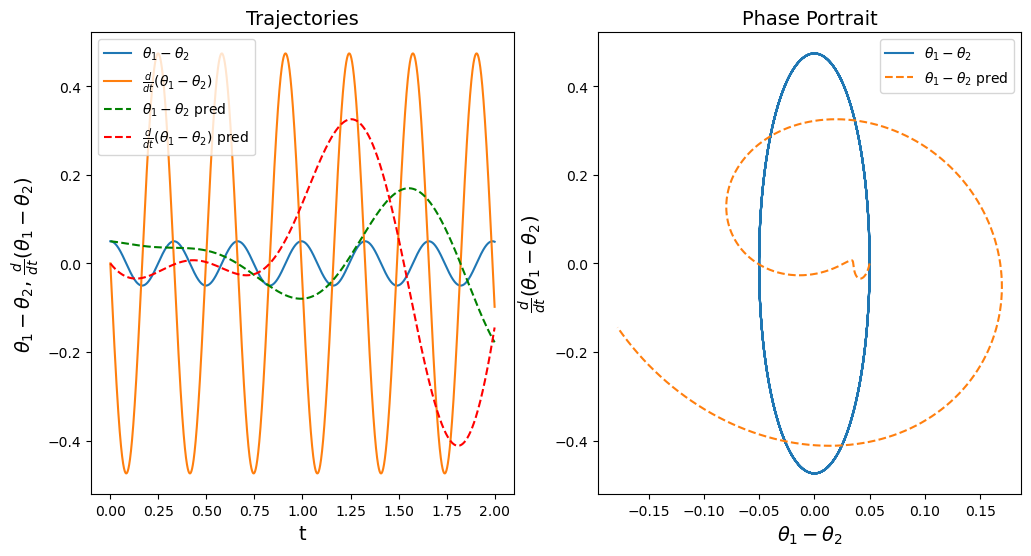

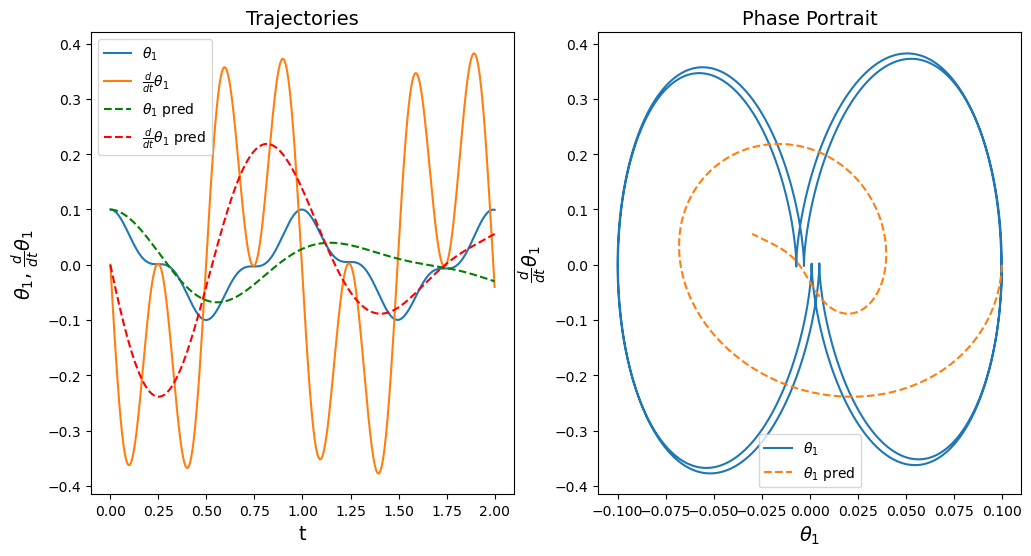

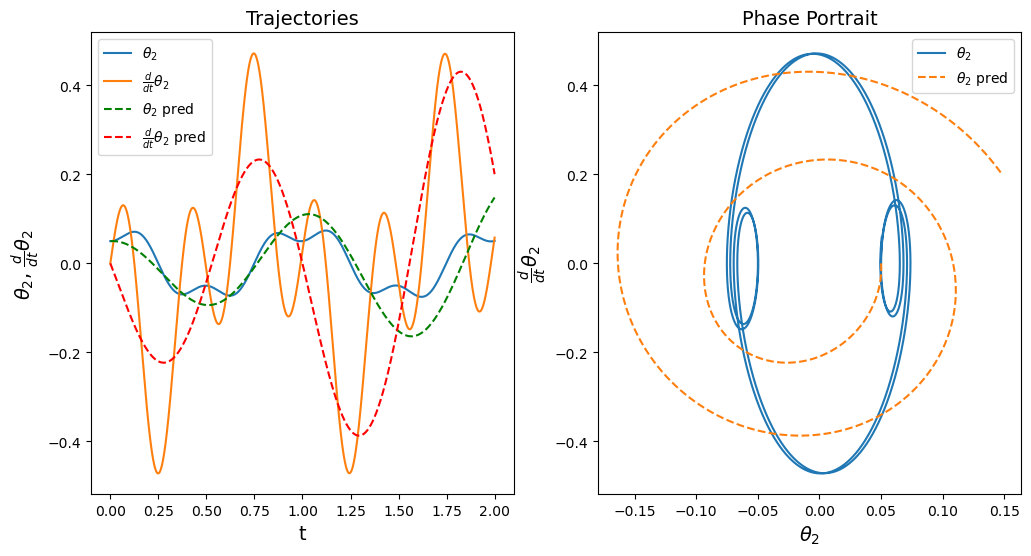

In [275]:
with torch.no_grad():
    pred_h = odeint(func, true_h0, test_t)
    visualize_sum(test_h, pred_h, save=True)
    visualize_difference(test_h, pred_h)
    visualize_1(test_h, pred_h)
    visualize_2(test_h, pred_h)